# Model 4 - UDE Framework (Multiple f(Y) per Dataset)

**System:**
$$\frac{dX}{dt} = f_i(Y) + aX(1 - X)$$
$$\frac{dY}{dt} = (bX - 1)Y$$

**Unknown:** Function $f_i(Y)$ for each dataset $i$, and Parameters $a, b$

**Note:** This model learns a **separate f(Y)** for each experiment/dataset

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from ude_framework import (
    create_neural_network,
    create_ude,
    UDETrainer,
    UDEEvaluator
)

%matplotlib inline
np.random.seed(42)
torch.manual_seed(42)

print("✓ UDE Framework loaded!")

✓ UDE Framework loaded!


In [2]:
# ============================================================================
# CONFIGURE EVERYTHING HERE
# ============================================================================

# ----------------------------------------------------------------------------
# 1. DATA FILES
# ----------------------------------------------------------------------------
# Choose which dataset to use (1 or 2)
DATASET_NUMBER = 1

INITIAL_CONDITIONS_FILE = f'model_4_dataset_{DATASET_NUMBER}_initial_conditions.csv'
MEASUREMENTS_FILES = [
    f'model_4_dataset_{DATASET_NUMBER}_measurements_1.csv',
    f'model_4_dataset_{DATASET_NUMBER}_measurements_2.csv',
    f'model_4_dataset_{DATASET_NUMBER}_measurements_3.csv'
]

# State variable names
STATE_NAMES = ['X', 'Y']

# Which states are observed in measurements
OBSERVED_STATES = ['Y']  # Only Y is measured
OBSERVED_INDICES = [STATE_NAMES.index(name) for name in OBSERVED_STATES]

# ----------------------------------------------------------------------------
# 2. NEURAL NETWORK CONFIGURATION (one per experiment)
# ----------------------------------------------------------------------------
NN_INPUT_DIM = 2   # f depends on time and Y
NN_OUTPUT_DIM = 1  # outputs f(Y)

def nn_input_extractor(y):
    """Extract Y (second state) for f(Y)"""
    return y[..., 1:2]  # Returns Y

# Architecture
NN_ARCHITECTURE = 'flexible'
NN_CONFIG = {
    'hidden_dims': [32, 32, 32, 32, 32, 32, 32],  # Very small network for stability
    'activation': 'relu',
    'final_activation': None,  # f(Y) can be any value
    'use_batch_norm': False,
    'dropout': 0.0
}

# ----------------------------------------------------------------------------
# 3. TRAINING CONFIGURATION
# ----------------------------------------------------------------------------
N_EPOCHS = 100
LEARNING_RATE = 1e-3
OPTIMIZER = 'adam'
WEIGHT_DECAY = 0.0
GRAD_CLIP = 1.0

SCHEDULER_TYPE = 'plateau'
SCHEDULER_PARAMS = {
    'factor': 0.5,
    'patience': 50,
    'min_lr': 1e-6,
    'verbose': False
}

ODE_SOLVER = 'rk4'  # Fixed-step solver - more stable than adaptive dopri5
ODE_RTOL = 1e-3  # Not used by rk4, but kept for compatibility
ODE_ATOL = 1e-5  # Not used by rk4, but kept for compatibility

LOSS_TYPE = 'mse'
STATE_WEIGHTS = [0.0, 1.0]  # Only fit Y (the observed state)

PRINT_EVERY = 15

# ----------------------------------------------------------------------------
# 4. VISUALIZATION OF LEARNED FUNCTION
# ----------------------------------------------------------------------------
FUNCTION_INPUT_RANGE = np.linspace(0, 6, 300)
FUNCTION_INPUT_NAME = 'Y Concentration'
FUNCTION_OUTPUT_NAME = 'f(Y) [Learned]'

print("✓ Configuration complete!")

✓ Configuration complete!


## 1. Load Data

In [3]:
# Load data from CSV files (multiple experiments)

# Load initial conditions (one row per experiment)
ic_df = pd.read_csv(INITIAL_CONDITIONS_FILE)
n_experiments = len(ic_df)

print(f"Found {n_experiments} experiments")
print(f"Initial conditions:")
print(ic_df)

# Load measurements for each experiment
experiments_data = []
for i in range(n_experiments):
    # Get initial condition for this experiment
    y0 = ic_df[STATE_NAMES].iloc[i].values
    
    # Load measurements
    measurements_df = pd.read_csv(MEASUREMENTS_FILES[i])
    t = measurements_df['t'].values
    y_measured = measurements_df[OBSERVED_STATES].values
    
    # Create full state arrays (we only observe Y, not X)
    n_points = len(t)
    n_states = len(STATE_NAMES)
    
    y_noisy = np.zeros((n_points, n_states))
    y_noisy[:, OBSERVED_INDICES] = y_measured
    y_true = y_noisy.copy()
    
    experiments_data.append({
        'exp_id': i,
        'y0': y0,
        't': t,
        'y_measured': y_measured,
        'y_noisy': y_noisy,
        'y_true': y_true
    })
    
    print(f"\nExperiment {i+1}:")
    print(f"  Initial conditions: {y0}")
    print(f"  Time points: {len(t)} from t={t[0]:.2f} to {t[-1]:.2f}")
    print(f"  Observed states: {OBSERVED_STATES}")

print(f"\n✓ Loaded data for {n_experiments} experiments")

Found 3 experiments
Initial conditions:
     X    Y
0  0.1  5.5
1  2.1  0.5
2  0.1  0.5

Experiment 1:
  Initial conditions: [0.1 5.5]
  Time points: 200 from t=0.00 to 5.00
  Observed states: ['Y']

Experiment 2:
  Initial conditions: [2.1 0.5]
  Time points: 200 from t=0.00 to 5.00
  Observed states: ['Y']

Experiment 3:
  Initial conditions: [0.1 0.5]
  Time points: 200 from t=0.00 to 5.00
  Observed states: ['Y']

✓ Loaded data for 3 experiments


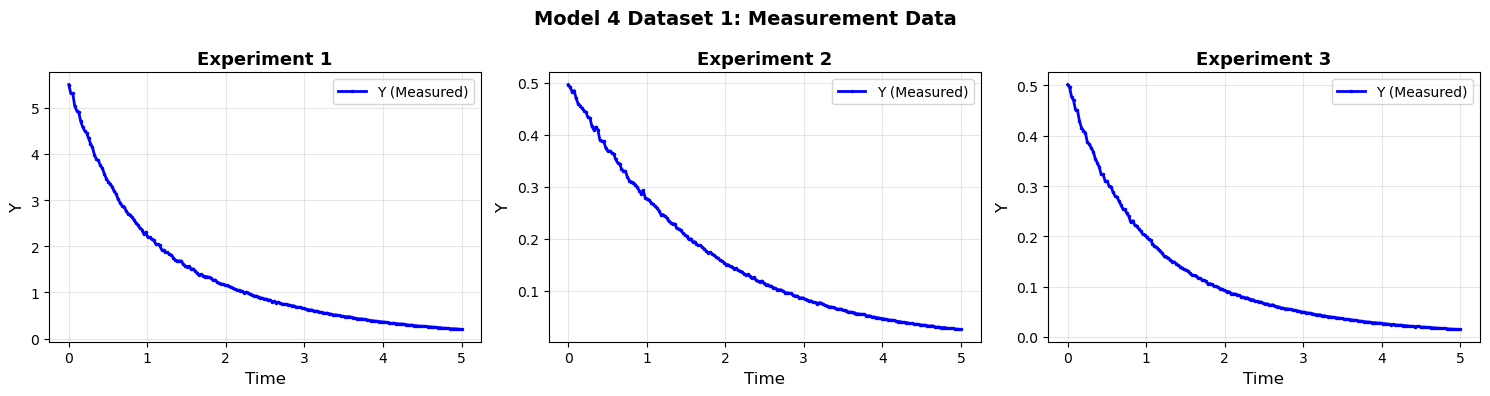

In [4]:
# Visualize all experiments
fig, axes = plt.subplots(1, n_experiments, figsize=(5*n_experiments, 4))
if n_experiments == 1:
    axes = [axes]

for i, exp_data in enumerate(experiments_data):
    ax = axes[i]
    y_idx = OBSERVED_INDICES[0]
    ax.plot(exp_data['t'], exp_data['y_noisy'][:, y_idx], 'b.-', 
            label=f'Y (Measured)', linewidth=2, markersize=3)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title(f'Experiment {i+1}', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Model 4 Dataset {DATASET_NUMBER}: Measurement Data', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Build UDE Models (One per Experiment)

In [5]:
# Wrap NN to extract correct input from state vector
class NNWrapper(nn.Module):
    def __init__(self, nn, input_extractor, output_scale=0.01):
        super().__init__()
        self.nn = nn
        self.input_extractor = input_extractor
        self.output_scale = output_scale  # Scale output to prevent instability
    
    def forward(self, t, y):
        nn_input = self.input_extractor(y)
        # Concatenate time with state inputs
        if nn_input.dim() == 1:
            t_expanded = t.unsqueeze(0) if t.dim() == 0 else t
        else:
            t_expanded = t.expand(nn_input.shape[0], 1) if t.dim() == 0 else t.unsqueeze(-1).expand(nn_input.shape[0], 1)
        
        full_input = torch.cat([t_expanded, nn_input], dim=-1)
        output = self.nn(t, full_input)
        return output * self.output_scale  # Scale down the output

# UDE ODE equations factory - creates a function that uses the correct NN for each experiment
def create_ude_ode_equations(exp_id):
    """Create UDE equations for a specific experiment"""
    def ude_ode_equations(t, y, nn_outputs, known_params):
        """
        UDE for Model 4:
        - KNOWN: nonlinear structure X(1-X) and (bX-1)Y
        - UNKNOWN: f_i(Y) learned by NN (different for each experiment i)
        - LEARNABLE PARAMETERS: a, b (shared across experiments)
        
        System equations:
        dX/dt = f_i(Y) + a*X*(1-X)
        dY/dt = (b*X - 1)*Y
        """
        X = y[..., 0:1]
        Y = y[..., 1:2]
        
        # Get NN output for f_i(Y) - specific to this experiment
        f_Y_nn = nn_outputs[f'f_Y_nn_{exp_id}']
        if f_Y_nn.dim() > 2:
            f_Y_nn = f_Y_nn.squeeze(-1)
        
        # Learnable parameters (shared)
        a = known_params.get('a_learnable', torch.tensor(1.0))
        b = known_params.get('b_learnable', torch.tensor(2.0))
        
        # Nonlinear system structure
        dX_dt = f_Y_nn + a * X * (1 - X)
        dY_dt = (b * X - 1) * Y
        
        return torch.cat([dX_dt, dY_dt], dim=-1)
    
    return ude_ode_equations

# Create neural networks and UDE models for each experiment
nn_models = []
ude_models = []
trainers = []

# Shared learnable parameters a and b
a_learnable = nn.Parameter(torch.tensor(0.1))  # Very small initial guess
b_learnable = nn.Parameter(torch.tensor(0.1))   # Very small initial guess

print("Creating UDE models for each experiment...\n")

for exp_id in range(n_experiments):
    # Create separate neural network for this experiment
    nn_model = create_neural_network(
        input_dim=NN_INPUT_DIM,
        output_dim=NN_OUTPUT_DIM,
        architecture=NN_ARCHITECTURE,
        **NN_CONFIG
    )
    
    wrapped_nn = NNWrapper(nn_model, nn_input_extractor, output_scale=0.01)
    
    # Create known params dict with shared parameters
    known_params = {
        'a_learnable': a_learnable,
        'b_learnable': b_learnable
    }
    
    # Create UDE for this experiment
    ude_model = create_ude(
        n_states=len(STATE_NAMES),
        ode_func=create_ude_ode_equations(exp_id),
        neural_networks={f'f_Y_nn_{exp_id}': wrapped_nn},
        known_params=known_params
    )
    
    # Register shared parameters (only on first model to avoid duplication)
    if exp_id == 0:
        ude_model.register_parameter('a_learnable', a_learnable)
        ude_model.register_parameter('b_learnable', b_learnable)
    
    nn_models.append(nn_model)
    ude_models.append(ude_model)
    
    print(f"Experiment {exp_id+1} UDE Model:")
    print(f"  NN parameters: {nn_model.count_parameters():,}")

print(f"\n✓ Created {n_experiments} UDE models!")
print(f"  Shared parameters: a={a_learnable.item():.4f}, b={b_learnable.item():.4f}")

Creating UDE models for each experiment...

Experiment 1 UDE Model:
  NN parameters: 6,465
Experiment 2 UDE Model:
  NN parameters: 6,465
Experiment 3 UDE Model:
  NN parameters: 6,465

✓ Created 3 UDE models!
  Shared parameters: a=0.1000, b=0.1000


## 3. Train UDEs (Each on its own experiment)

In [6]:
# Create trainers for each experiment
for ude_model in ude_models:
    trainer = UDETrainer(
        ude_model=ude_model,
        optimizer_name=OPTIMIZER,
        learning_rate=LEARNING_RATE,
        scheduler_type=SCHEDULER_TYPE,
        scheduler_params=SCHEDULER_PARAMS,
        weight_decay=WEIGHT_DECAY,
        grad_clip=GRAD_CLIP,
        ode_solver=ODE_SOLVER,
        ode_rtol=ODE_RTOL,
        ode_atol=ODE_ATOL
    )
    trainers.append(trainer)

print(f"✓ Created {n_experiments} trainers")

✓ Created 3 trainers


/opt/miniconda3/envs/himanshu-quant-research/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
# Train all experiments
print(f"\n{'='*60}")
print(f"TRAINING ({N_EPOCHS} epochs) - Separate f(Y) per experiment")
print(f"{'='*60}\n")

# Convert weights to tensor if provided
weights_torch = torch.tensor(STATE_WEIGHTS, dtype=torch.float32) if STATE_WEIGHTS is not None else None

# Training loop
for epoch in range(1, N_EPOCHS + 1):
    total_loss = 0.0
    
    # Train each experiment with its own UDE
    for exp_id, (trainer, exp_data) in enumerate(zip(trainers, experiments_data)):
        y0_torch = torch.tensor(exp_data['y0'], dtype=torch.float32)
        t_torch = torch.tensor(exp_data['t'], dtype=torch.float32)
        y_true_torch = torch.tensor(exp_data['y_noisy'], dtype=torch.float32)
        
        # Single training step for this experiment
        loss_dict = trainer.train_step(y0_torch, t_torch, y_true_torch, weights=weights_torch, loss_type=LOSS_TYPE)
        total_loss += loss_dict['loss']
        
        # Scheduler step
        if trainer.scheduler:
            if isinstance(trainer.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                trainer.scheduler.step(loss_dict['loss'])
            else:
                trainer.scheduler.step()
    
    # Average loss across experiments
    avg_loss = total_loss / n_experiments
    
    # Print progress
    if epoch == 1 or epoch % PRINT_EVERY == 0:
        lr = trainers[0].scheduler.get_last_lr()[0] if trainers[0].scheduler else LEARNING_RATE
        print(f"Epoch {epoch}/{N_EPOCHS} | Avg Loss: {avg_loss:.6f} | LR: {lr:.6f}")

print(f"\n✓ Training complete!")
print(f"  Learned a: {a_learnable.item():.4f}")
print(f"  Learned b: {b_learnable.item():.4f}")


TRAINING (100 epochs) - Separate f(Y) per experiment

Epoch 1/100 | Avg Loss: 0.027463 | LR: 0.001000
Epoch 15/100 | Avg Loss: 0.027003 | LR: 0.001000
Epoch 30/100 | Avg Loss: 0.026475 | LR: 0.001000
Epoch 45/100 | Avg Loss: 0.025638 | LR: 0.001000
Epoch 60/100 | Avg Loss: 0.022139 | LR: 0.001000
Epoch 75/100 | Avg Loss: 0.003640 | LR: 0.001000
Epoch 90/100 | Avg Loss: 0.001034 | LR: 0.001000

✓ Training complete!
  Learned a: 0.2058
  Learned b: 0.1884


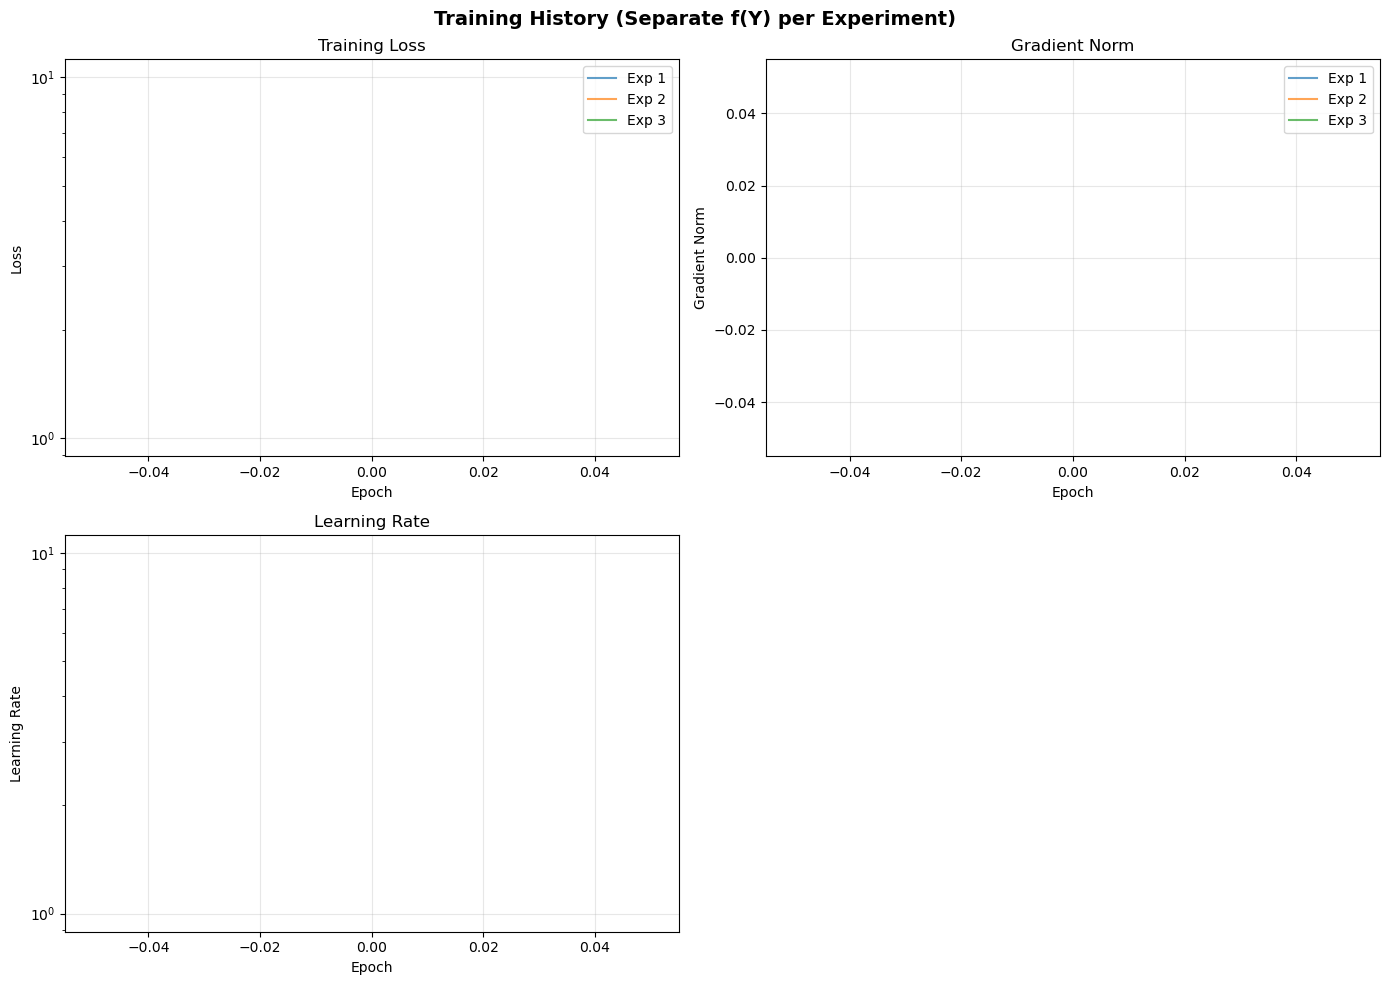

In [8]:
# Plot training history for each experiment
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for exp_id, trainer in enumerate(trainers):
    history = trainer.get_history()
    
    # Loss
    axes[0, 0].plot(history['loss'], label=f'Exp {exp_id+1}', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_yscale('log')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Gradient norm
    axes[0, 1].plot(history['grad_norm'], label=f'Exp {exp_id+1}', alpha=0.7)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Gradient Norm')
    axes[0, 1].set_title('Gradient Norm')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Learning rate (same for all)
axes[1, 0].plot(trainers[0].get_history()['learning_rate'])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Learning Rate')
axes[1, 0].grid(True, alpha=0.3)

# Hide empty subplot
axes[1, 1].axis('off')

plt.suptitle('Training History (Separate f(Y) per Experiment)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Evaluate UDE Performance

In [9]:
# Get predictions for all experiments
predictions = []
for exp_id, (trainer, exp_data) in enumerate(zip(trainers, experiments_data)):
    y0_torch = torch.tensor(exp_data['y0'], dtype=torch.float32)
    t_torch = torch.tensor(exp_data['t'], dtype=torch.float32)
    
    with torch.no_grad():
        y_pred = trainer.forward_solve(y0_torch, t_torch).numpy()
    
    predictions.append(y_pred)
    
    # Compute metrics (only for Y, the observed state)
    y_idx = OBSERVED_INDICES[0]
    y_true = exp_data['y_true'][:, y_idx]
    y_pred_state = y_pred[:, y_idx]
    
    mse = np.mean((y_pred_state - y_true)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_pred_state - y_true))
    
    print(f"\nExperiment {exp_id+1} Metrics (for Y):")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")


Experiment 1 Metrics (for Y):
  MSE:  0.001701
  RMSE: 0.041242
  MAE:  0.033786

Experiment 2 Metrics (for Y):
  MSE:  0.000053
  RMSE: 0.007248
  MAE:  0.006060

Experiment 3 Metrics (for Y):
  MSE:  0.000226
  RMSE: 0.015037
  MAE:  0.013844


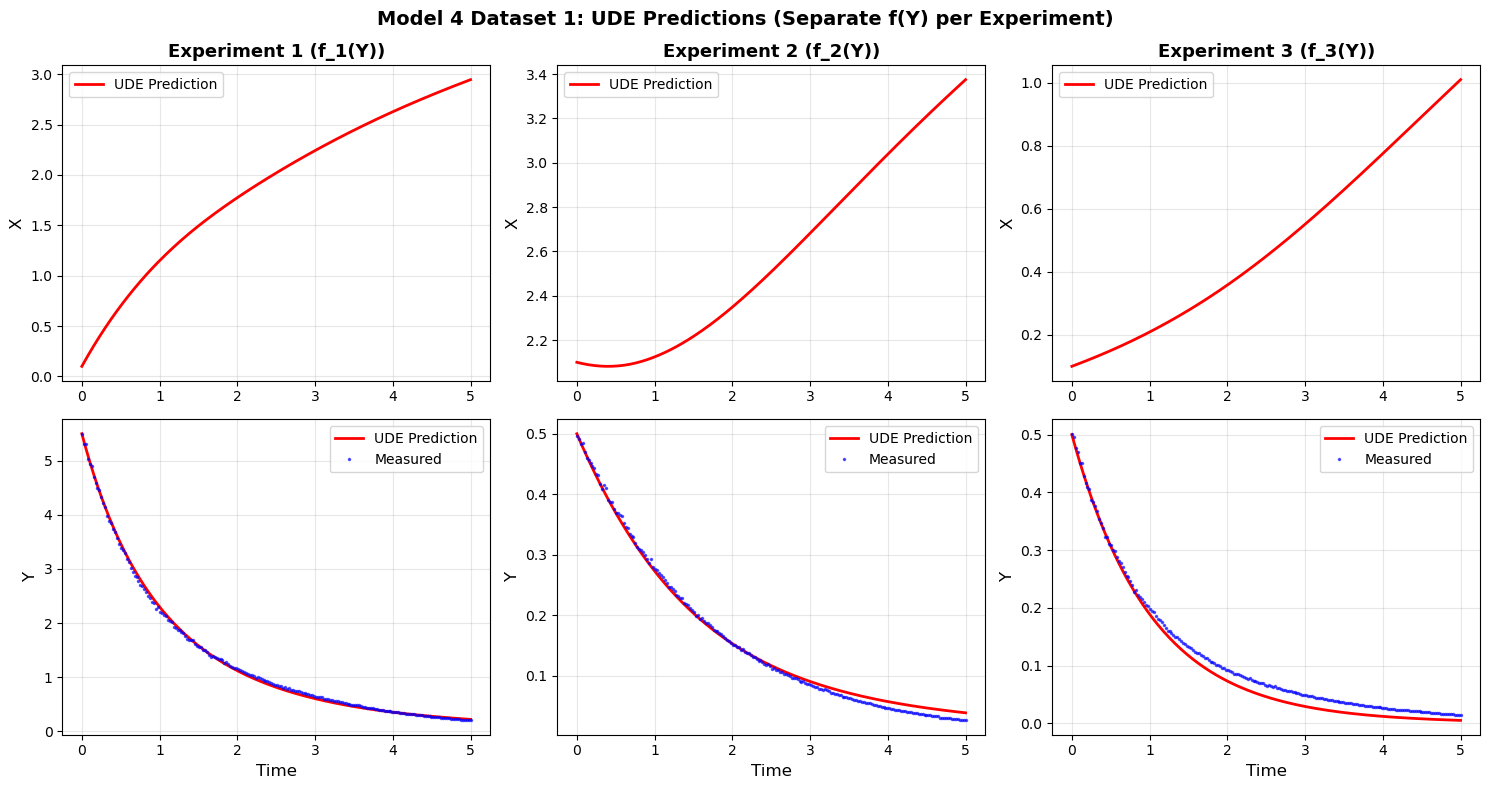

In [10]:
# Plot trajectories for all experiments
fig, axes = plt.subplots(len(STATE_NAMES), n_experiments, 
                         figsize=(5*n_experiments, 4*len(STATE_NAMES)))

if n_experiments == 1:
    axes = axes.reshape(-1, 1)

for exp_idx, (exp_data, y_pred) in enumerate(zip(experiments_data, predictions)):
    t = exp_data['t']
    y_true = exp_data['y_true']
    
    for state_idx, name in enumerate(STATE_NAMES):
        ax = axes[state_idx, exp_idx]
        ax.plot(t, y_pred[:, state_idx], 'r-', label='UDE Prediction', linewidth=2)
        
        # Only plot measurements for Y
        if state_idx == OBSERVED_INDICES[0]:
            ax.plot(t, y_true[:, state_idx], 'b.', label='Measured', alpha=0.6, markersize=3)
        
        ax.set_ylabel(name, fontsize=12)
        if state_idx == 0:
            ax.set_title(f'Experiment {exp_idx+1} (f_{exp_idx+1}(Y))', fontsize=13, fontweight='bold')
        if state_idx == len(STATE_NAMES) - 1:
            ax.set_xlabel('Time', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle(f'Model 4 Dataset {DATASET_NUMBER}: UDE Predictions (Separate f(Y) per Experiment)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Visualize All Learned Functions f_i(Y)

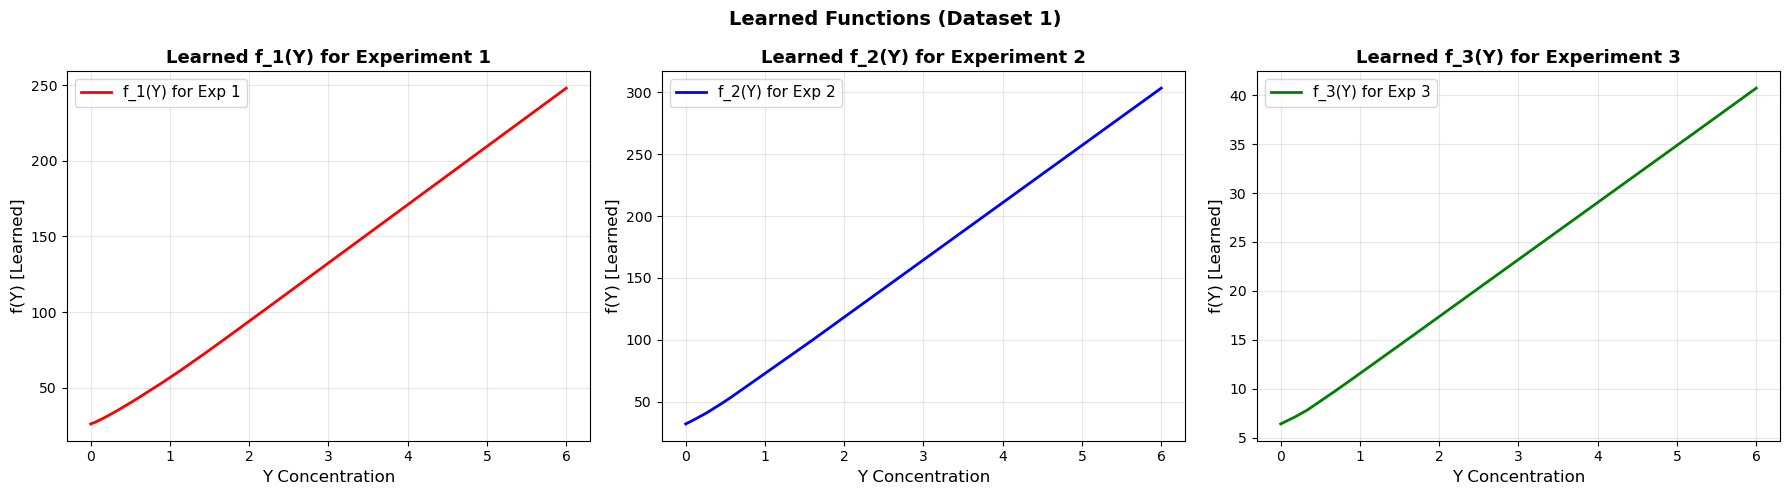

In [11]:
# Visualize all learned f_i(Y) functions
t_range = torch.tensor(FUNCTION_INPUT_RANGE.reshape(-1, 1), dtype=torch.float32)
y_range = torch.tensor(FUNCTION_INPUT_RANGE.reshape(-1, 1), dtype=torch.float32)
full_input = torch.cat([t_range, y_range], dim=-1)

# Create separate plots
fig, axes = plt.subplots(1, n_experiments, figsize=(6*n_experiments, 5))
if n_experiments == 1:
    axes = [axes]

colors = ['red', 'blue', 'green', 'purple', 'orange']

for exp_id, nn_model in enumerate(nn_models):
    with torch.no_grad():
        f_Y_learned = nn_model(t_range[:, 0], full_input).numpy()
    
    ax = axes[exp_id]
    color = colors[exp_id % len(colors)]
    ax.plot(FUNCTION_INPUT_RANGE, f_Y_learned, '-', color=color, linewidth=2, 
            label=f'f_{exp_id+1}(Y) for Exp {exp_id+1}')
    ax.set_xlabel(FUNCTION_INPUT_NAME, fontsize=12)
    ax.set_ylabel(FUNCTION_OUTPUT_NAME, fontsize=12)
    ax.set_title(f'Learned f_{exp_id+1}(Y) for Experiment {exp_id+1}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Learned Functions (Dataset {DATASET_NUMBER})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

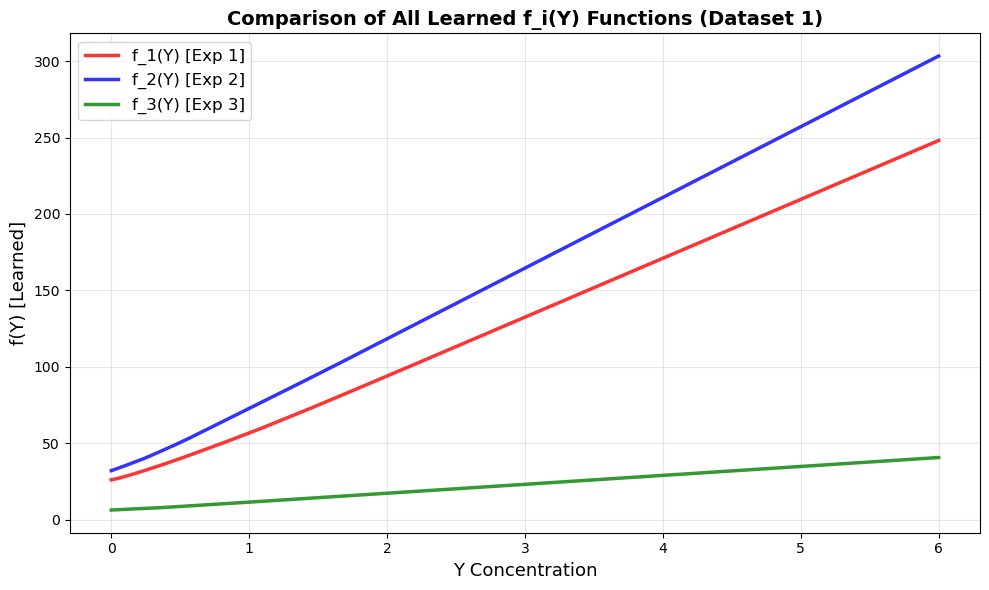

In [12]:
# Overlay all functions for comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for exp_id, nn_model in enumerate(nn_models):
    with torch.no_grad():
        f_Y_learned = nn_model(t_range[:, 0], full_input).numpy()
    
    color = colors[exp_id % len(colors)]
    ax.plot(FUNCTION_INPUT_RANGE, f_Y_learned, '-', color=color, linewidth=2.5, 
            label=f'f_{exp_id+1}(Y) [Exp {exp_id+1}]', alpha=0.8)

ax.set_xlabel(FUNCTION_INPUT_NAME, fontsize=13)
ax.set_ylabel(FUNCTION_OUTPUT_NAME, fontsize=13)
ax.set_title(f'Comparison of All Learned f_i(Y) Functions (Dataset {DATASET_NUMBER})', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Parameter Summary

In [13]:
# Display learned parameters
print("\n" + "="*60)
print("LEARNED PARAMETERS")
print("="*60)
print(f"\nShared Parameter a (growth rate):")
print(f"  Learned value: {a_learnable.item():.4f}")
print(f"\nShared Parameter b (coupling strength):")
print(f"  Learned value: {b_learnable.item():.4f}")
print(f"\nNeural Networks (one per experiment):")
print(f"  Number of NNs: {n_experiments}")
print(f"  Parameters per NN: {nn_models[0].count_parameters():,}")
print(f"  Total NN parameters: {sum(nn.count_parameters() for nn in nn_models):,}")
print(f"  Architecture: {NN_INPUT_DIM} -> {' -> '.join(map(str, NN_CONFIG['hidden_dims']))} -> {NN_OUTPUT_DIM}")
print(f"  Activation: {NN_CONFIG['activation']}")
print("\n" + "="*60)
print("KEY INSIGHT:")
print("Each experiment has its own f_i(Y) function, allowing the model")
print("to capture different dynamics across datasets while sharing")
print("the same structural parameters a and b.")
print("="*60)


LEARNED PARAMETERS

Shared Parameter a (growth rate):
  Learned value: 0.2058

Shared Parameter b (coupling strength):
  Learned value: 0.1884

Neural Networks (one per experiment):
  Number of NNs: 3
  Parameters per NN: 6,465
  Total NN parameters: 19,395
  Architecture: 2 -> 32 -> 32 -> 32 -> 32 -> 32 -> 32 -> 32 -> 1
  Activation: relu

KEY INSIGHT:
Each experiment has its own f_i(Y) function, allowing the model
to capture different dynamics across datasets while sharing
the same structural parameters a and b.
